# SC42150 - Statistical Signal Processing
## Python Assignment II: Denoising with an FIR filter.


#### Team members
- Name (student number): Maria de Neves de Fonseca (5611679)
- Name (student number): Qingyi Ren (5684803)
---


## Introduction

You have recently gotten involved in amateur RF communication, and you have finally managed to trasnmit a signal wirelessly! Your setup constists of one broadcasting and one receiving antenna. To test out the setup, you sent three short recordings of piano notes. Upon receiving them however, you realise that they have been corrupted by noise. So now you want to apply what you have learned in the Statistical Signal Processing course and try to remove the noise. Since the nature of the interference is stochastic, you want to subtract the effects of the distortion by using the theory of Wiener filters.

In the configuration of the figure below, all signals are discrete-time and real.
The corrupted signal $x(n) = d(n) + v(n)$ contains both the signal of interest $d(n)$ and a noise $v(n)$ which is _uncorrelated_ to $d(n)$.
In this assignment you will design a FIR filter $W(z)$, such that we can estimate the ground truth signal from $x(n)$ and from the statistical properties of the noise.

![alt text][denoising]

[denoising]: ./denoising-scheme.JPG

## Reporting

The report of this python exercise consists of this Jupyter Notebook file, with your answers added after each question. Answers will consist of code and/or text (markdown) cells. Please use the already indicated cells and format. You will **also** need to deliver a `PDF` version of this file.

In order to create a PDF version of this file, go to the top left, click on `File` then `Export Notebook As` and Choose `PDF`.
If this feature is not supported by your system, you can also choose `LaTeX`.
Then, you can use your preferred `LaTeX` compiler to create the `PDF`. After generation you PDF report, please double check if all answers/plots are correctly displayed.

In your submission, please also include the provided `.mat` files. Don't forget to edit your team member's name and student number above. You will submit one Jupyter notebook per team.

### Loading files

As mentioned before, you have three recordings available in the form of `notes_xxx.mat` files, one for each of the tests you ran. Furthermore, you have obtained a recording of the passive noise present in the system (`noise.mat`). Run this section in order to load the `.mat` files with the noise audios and the background noise signals.

In [35]:
# packages
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.linalg as lin
import scipy.signal as sig

# use this function to play the signals
# be careful when using headphones!
def play_signal( signal ):
    sd.play( signal.astype('int16'), 22050 )

# notes to be played
notes = np.array( ['Do','Sol','La'] )

# number of experiments
N_exp = notes.shape[0]

print( f'Number of experiments = {N_exp}' )

# list of files for all experiments with audio
filenames = ['notes_do.mat', 'notes_sol.mat', 'notes_la.mat']

# Number of data points
N = len( sio.loadmat( filenames[0] )['audio'][0] )

# create array with received data
data_noised = np.zeros( (N_exp, N), dtype=float )
for iexp in range(N_exp):
    data_noised[iexp] = sio.loadmat( filenames[iexp] )['audio'][0]

# array for the time steps
time_steps = np.linspace( 0, N-1, N ).astype( int )
print( f'Number of recording time steps = {N}' )

# load background noise signal that was measured

filename_noise = 'noise.mat'
data_mat = sio.loadmat( filename_noise )['audio'][0]

Nnoise = len( data_mat )
noise_measured = np.array( data_mat, dtype=float )

print( f'Number of noise time steps = {Nnoise}' )

Number of experiments = 3
Number of recording time steps = 40305
Number of noise time steps = 40305


In [36]:
# listen the noised audio signals
ind_to_listen = 0
play_signal( data_noised[ind_to_listen] )

# Exercises
This part should be handled after all audio files were uploaded into *data_noised* array and the noise was uploaded into *noise_measured* file.

**1. (10 points)** Formulate the denoising problem as a Minimum Variance FIR Wiener Problem, using the symbols $x(n)$, $v(n)$, $d(n)$, $\hat{d}(n)$, $e(n)$ as in the figure presented in the **Introduction**.
No numerical values are required, but you need to specify the meaning of all the symbols and their relation to the sent and received data.


> The corrupted signal $x(n) = d(n) + v(n)$ contains both the signal of interest $d(n)$ and a noise $v(n)$ which is _uncorrelated_ to $d(n)$.
>
> The FIR Wiener filter represented in the block diagram from the introduction can be mathematically defined as $W(z;w(j))=\sum_{j=0}^{m-1}w(j)z^{-j}$. This leads to the following relation between the input and the output:
> $\hat{d}(n)=\sum^{m-1}_{i=0}w(i)x(n-i)$
>which is a finite sum, and therefore the impulse response is finite, explaining the name FIR model.
>
> For this model the Minimum Variance FIR Wiener Problem can now be stated as:
> $\underset{w(i)}{min} \quad J(w(j)) \quad \text{for} \quad J(w(j))=E[|e(n;w(j))|^2]$.
>
>The residual error is denoted $e(n)$ and is defined as $e(n) = d(n)-\hat{d}(n)$ as seen in the block diagram in the introduction. The Wiener filter is designed so as to minimize the mean square error as follows:  $w(j)=arg \min E[e^2(n)]$ with $E[e^2(n)]=E[(d(n)-\hat{d}(n))^2]=E[d(n)^2-2d(n)\hat{d}(n)+\hat{d}(n)^2]=E[d(n)^2]+E[(\sum^{m-1}_{i=0}w(i)x(n-i))^2]-2E[\sum^{m-1}_{i=0}w(i)x(n-i)d(n)]$


**2. (5 points)** Plot the graphs for the received audio signals and the received noise signal.
Use a separate plot for the noise signal.

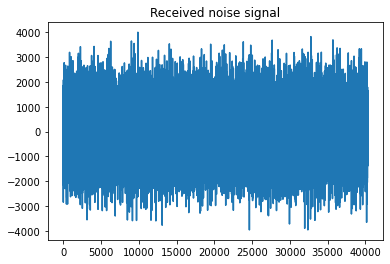

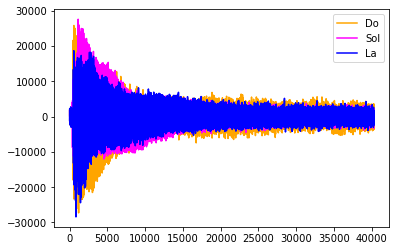

In [37]:
plt.figure()
plt.plot(time_steps, noise_measured)
plt.title('Received noise signal')
plt.show()

plt.figure()
plt.plot(time_steps, data_noised[0], 'orange', label='Do')
plt.plot(time_steps, data_noised[1], 'magenta', label='Sol')
plt.plot(time_steps, data_noised[2], 'blue', label='La')
plt.legend()
plt.show()


**3. (15 points)** Determine the Wiener-Hopf equation for the denoising case with filter order $m$.
What assumptions are we making for the audio signal and the noise in order to obtain the values of the filter $w$?
Derive how can we calculate the right hand side of the Wiener-Hopf equation assuming that we know $r_x(k), \; \forall k$ 
and the noise variance $\sigma^2_v$.

>Having the following vectors defined as 
>
>$x^*(n)=\begin{bmatrix}x^*(n) \\ \vdots \\ x^*(n-m+1) \end{bmatrix}$ and $w=\begin{bmatrix}w(0) \\ \vdots \\ w(m-1) \end{bmatrix}$
>
>and the following covariance matrix and cross-correlation vector
>
>$R_x=E[x^*(n)x(n)^T]>0$ and $r_{dx}=E[d(n)x^*(n)]$
>
>we can now determine the Wiener-Hopf equation for the denoising case with filter order $m$ as shown bellow. 
>
>From the reader: $\textbf{Theorem 9.1}$ (FIR Wiener Filter) Let the conditions as stipulated in the generic problem formulation given in question 1 hold, let the stochastic processes $x(n)$ and $d(n)$ be jointly zero mean and WSS and let the Auto-correlation function of $d(n)$ be denoted as
$r_d(k)$. With these assumptions for the audio signal and the noise we can obtain the coeficients $w$ of the Wiener filter as follows: 
>
>$\begin{align}J(w) = E[|e(n;w)|^2] 
= E[|d(n)-\hat{d}(n;w)|^2]=E[|d(n)-\sum^{m-1}_{l=0}w(l)x(n-l)|^2]\end{align}$
>
> Using this expression for J(w) we can take its derivative with respect to the parameters w(l):
>
>$\begin{bmatrix}E\left[\frac{\partial e(n;w)e^*(n;w)}{w^*(0)}\right] \\ \vdots \\ E\left[\frac{\partial e(n;w)e^*(n;w)}{w^*(m-1)}\right]  \end{bmatrix} = \begin{bmatrix}E\left[e(n;w)\frac{\partial e^*(n;w)}{w^*(0)}\right] \\ \vdots \\ E\left[e(n;w)\frac{\partial e^*(n;w)}{w^*(m-1)}\right]  \end{bmatrix}=E\left[e(n;\hat{w}) \begin{bmatrix}x^*(n) \\ \vdots \\ x^*(n-m+1) \end{bmatrix}\right]$
>
>To find the values of $w$ that minimise $J(w)$ we equal the derivative to 0:
>
>$E\left[e(n;\hat{w}) \begin{bmatrix}x^*(n) \\ \vdots \\ x^*(n-m+1) \end{bmatrix}\right] = 0$
>
>with $e(n;\hat{w}) = d(n)-[x(n) \cdots x(n-m+1)]\hat{w}$
>
>So we have that 
>
>$E\left[d(n)\begin{bmatrix}x^*(n) \\ \vdots \\ x^*(n-m+1) \end{bmatrix}\right]- E\left[\begin{bmatrix}x^*(n) \\ \vdots \\ x^*(n-m+1) \end{bmatrix}[x(n) \cdots x(n-m+1)]\right]\hat{w}= 0 \Leftrightarrow r_{dx}-R_x\hat{w}=0$
>
>which represents the Wiener-Hopf equation. So assuming that we know $r_x(k),\forall k$ and the noise variance $\sigma_v^2$ the solution to the Wiener-Hopf equation is given as $\hat{w}=R_x^{-1}r_{dx}$.
>
>Using the relation between $x(n)$ and $d(n)$ as given in question 1 we have that
>
>$r_x(k) = E[(d(n)+v(n))(d^*(n-k)+v^*(n-k))] = E[d(n)d^*(n-k)]+E[d(n)v^*(n-k)]+E[v(n)d^*(n-k)]+E[v(n)v^*(n-k)]
= r_d(k)+r_v(k)$ (since we have that the additive noise $v(n)$ is assumed to be uncorrelated to $d(n)$ we have that $E[v(n)d^*(n-k)]=E[d(n)v^*(n-k)]=0$. We also assume that we know the noise variance and the noise is ZMWN and, thus, $r_v(k)=\sigma_v^2\delta(k)$ from $\textbf{Definition 6.6}$ from the reader).
>
>$r_{dx}(k) = E[d(n)(d^*(n − k) + v^*(n − k))]= r_d(k) \Leftrightarrow r_{dx}(k)=r_x(k)-r_v(k) \Leftrightarrow r_{dx}(k)=r_x(k)-\sigma_v^2\delta(k)$
>
> We can now define the right hand side of the Wiener-Hopf equation in function of the noise variance $\sigma_v^2$, $r_x(k)$ and the covariance matrix $R_x$ as follows 
>
>$\hat{w}=R_x^{-1}r_{dx}\Leftrightarrow \hat{w}=R_x^{-1}(r_x(k)-\sigma_v^2\delta(k))$

**4. (10 points)** Using your background noise measurement, estimate its mean and variance ($\sigma^2_v$). Print these estimates.

Next, compute and plot the noise auto-correlation function of the measured noise for lags $0..9$. Is the signal ZMWN? Explain your answer.

**Note:** if the signal $x(n)$ is auto-correlation ergodic,
the auto-correlation function $r_x(k)$ can be estimated as
(if we have only values $x_1, x_2, \dots, x_N$):
$$
    r_x(k) = \frac{1}{N-k} \sum_{i=k+1}^{N} x(i) x^*(i-k)
$$

**Note:** if you are unfamiliar with python, take care when copying `np.arrays`. Read more [here](https://numpy.org/doc/stable/reference/generated/numpy.copy.html).

Mean= 5.4170357109901355
Variance= 1001140.3556802921
rv(k)= [1001094.6525815588, 5877.588301423162, 3263.3660517579756, -5651.721435914082, -310.0721360872903, 8271.815142552136, -7208.166681377408, 2778.778687921224, -85.57037457795549, -4023.1864590848827]


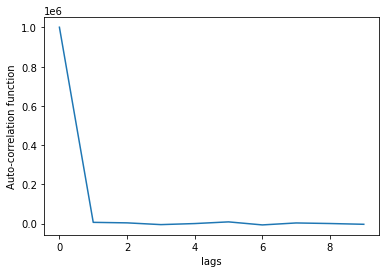

In [38]:
mean = noise_measured.mean()
var = noise_measured.var()

print('Mean=', mean)
print('Variance=', var)

v = noise_measured
r_v = []
N_order = 10

for k in range(0,N_order):
    a = 0
    for i in range(k+1,Nnoise):
        a = a+v[i]*np.conjugate(v[i-k])
    r_v.append(a/(Nnoise-k))

print("rv(k)=",r_v)

x_axis = np.linspace(0,N_order-1,N_order)
plt.plot(x_axis, r_v)
plt.xlabel("lags")
plt.ylabel("Auto-correlation function")
plt.show()

> (From the reader) **Definition 6.6** (Zero-mean White Noise ZMWN) A stochastic process $x(n)\in\mathbb{C}$ is Zero-mean White Noise (ZMWN) provided it (1) has zero mean, (2) it is WSS and (3) its Auto-correlation function is given as $r_v(k)=\sigma_v^2\delta(k)$.
>
>From the plots from question 2 we can see that the noise signal seems to be stationary and, even though its mean is around 5.417, it is still very close to 0 mean when compared to the amplitudes of the signal, which are around 4000. Thus, we can assume that the first condition from the definition above is met. 
>
>Now to check the second point, we know that a stochastic process $x(n)$ is Wide-Sense Stationary (WSS) if it satisfies the following three criteria,
>1. $m_x(k) = m_x < \infty$
>2. $r_x(k, l) = r_x(k−l) \forall k,l$
>3. $c_x(0) < \infty$, i.e. its variance is finite.
>
>As said before from the plot of the noise signal we can see that this stochastic process is stationary and therefore it already checks the first criteria since it has constant and finite mean. As for the third criteria we also know that its variance for lag 0 is finite and equal to ~1001140.356. However, since we only have one signal, we do not have enough information to check the second criteria. 
>
>In an attempt to conclude if the noise is ZMWN, we check that properties from 5.8 to 5.10 (from the reader) are met. Thus, we still conclude that the noise is ZMWN.   

**5. (10 points)** Assuming the ergodicity property of the  audio signals, calculate the auto-correlation function $r_x(k)$ of every received audio signal for lags $0,\dots,9$. Print these values.

Next, calculate the cross-correlation function $r_{dx}(k)$ of every received audio signal for lags $0,\dots,9$. Print these values.

For Do: rx(k)= [14718282.524452796, 13432839.135685261, 12574241.71798588, 11303923.357353274, 9723720.853620354, 7964478.385344366, 6145694.768142791, 4332461.621875379, 2550030.7487715306, 909973.5572435019]
For Sol: rx(k)= [13388392.62993973, 12248910.448876038, 11843410.94968438, 11210025.464390477, 10410337.043207461, 9448087.199526284, 8383849.6529738335, 7201535.908904103, 5947316.32024534, 4628338.748164269]
For La: rx(k)= [9453354.498118885, 8214526.418606475, 7553882.411406142, 6598931.024023744, 5463943.758430627, 4224846.912954713, 3012178.3511366495, 1845535.7623576561, 757725.1116361846, -217472.92033064528]
For Do: rdx(k)= [13717187.87187124 13426961.54738384 12570978.35193412 11309575.07878919
  9724030.92575644  7956206.57020181  6152902.93482417  4329682.84318746
  2550116.31914611   913996.74370259]
For Sol: rdx(k)= [12387297.97735817 12243032.86057461 11840147.58363262 11215677.18582639
 10410647.11534355  9439815.38438373  8391057.81965521  7198757.13021618
  59474

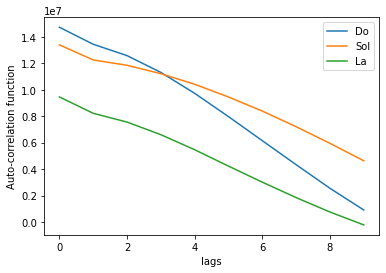

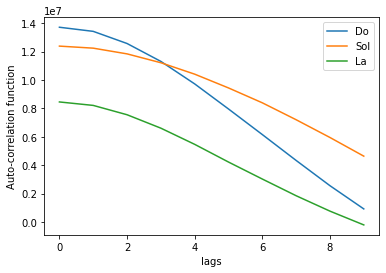

In [39]:
x_0 = data_noised[0]
x_1 = data_noised[1]
x_2 = data_noised[2]
r_x_0 = []
r_x_1 = []
r_x_2 = []
N_order = 10

for k in range(0,N_order):
    a = 0
    b = 0
    c = 0
    for i in range(k+1,N):
        a = a+x_0[i]*np.conjugate(x_0[i-k])
        b = b+x_1[i]*np.conjugate(x_1[i-k])
        c = c+x_2[i]*np.conjugate(x_2[i-k])
    r_x_0.append(a/(N-k))
    r_x_1.append(b/(N-k))
    r_x_2.append(c/(N-k))

print("For Do: rx(k)=",r_x_0)
print("For Sol: rx(k)=",r_x_1)
print("For La: rx(k)=",r_x_2)

r_d_x_0 = np.subtract(r_x_0,r_v)
print("For Do: rdx(k)=",r_d_x_0)
r_d_x_1 = np.subtract(r_x_1,r_v)
print("For Sol: rdx(k)=",r_d_x_1)
r_d_x_2 = np.subtract(r_x_2,r_v)
print("For La: rdx(k)=",r_d_x_2)

plt.figure()
x_axis = np.linspace(0,N_order-1,N_order)
plt.plot(x_axis, r_x_0, label = 'Do')
plt.plot(x_axis, r_x_1, label = 'Sol')
plt.plot(x_axis, r_x_2, label = 'La')
plt.xlabel("lags")
plt.ylabel("Auto-correlation function")
plt.legend()
plt.show()

plt.figure()
x_axis = np.linspace(0,N_order-1,N_order)
plt.plot(x_axis, r_d_x_0, label = 'Do')
plt.plot(x_axis, r_d_x_1, label = 'Sol')
plt.plot(x_axis, r_d_x_2, label = 'La')
plt.xlabel("lags")
plt.ylabel("Auto-correlation function")
plt.legend()
plt.show()

**6. (10 points)** Using a 10-th order FIR Wiener filter, calculate the optimal filter coefficients for every received audio signal. Print these values.

**Note:** The `sp.linalg.toeplitz()` function may be useful.

In [40]:
w_0 = np.dot(lin.inv(lin.toeplitz(r_x_0)),(r_d_x_0))
print("optimal filter coefficients for Do:", w_0) 
w_1 = np.dot(lin.inv(lin.toeplitz(r_x_1)),(r_d_x_1))
print("optimal filter coefficients for Do:", w_1) 
w_2 = np.dot(lin.inv(lin.toeplitz(r_x_2)),(r_d_x_2))
print("optimal filter coefficients for Do:", w_2) 

optimal filter coefficients for Do: [ 0.52978738  0.33215969  0.14578224  0.03958803 -0.02598108 -0.04858735
 -0.01578035 -0.00918522 -0.01561838 -0.0072667 ]
optimal filter coefficients for Do: [ 4.31139801e-01  3.04528533e-01  1.85196952e-01  9.63683096e-02
  3.68762421e-02 -8.46901881e-03 -1.12407238e-04 -2.66630484e-02
 -3.76156295e-02 -5.96277067e-02]
optimal filter coefficients for Do: [ 0.51377187  0.31809705  0.14415978  0.03968126 -0.01772953 -0.04821135
 -0.01403858 -0.01166698 -0.00938027 -0.01398167]


**7. (15 points)** Using the computed filter coefficients, compute an estimate of the denoised audio signals from the received ones.

Plot together the denoised signal with the originally received one. Draw one plot for every audio signal.

Use the `play_signal()` function in order to play the denoised signals - do you hear the difference between the originally received and the denoised one? 

**Note:** the `sp.signal.lfilter()` function can be useful when using the Wiener filter.

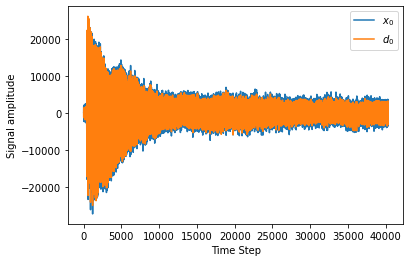

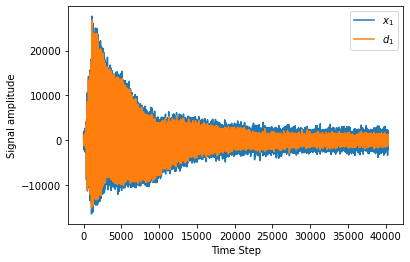

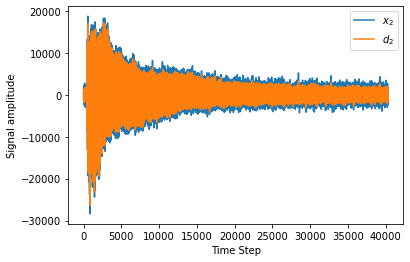

In [41]:
a_coef_0 = np.concatenate(([1], np.zeros(w_0.size-1)))
a_coef_1 = np.concatenate(([1], np.zeros(w_1.size-1)))
a_coef_2 = np.concatenate(([1], np.zeros(w_2.size-1)))
signal_0 = sig.lfilter(w_0,a_coef_0,x_0)
signal_1 = sig.lfilter(w_1,a_coef_1,x_1)
signal_2 = sig.lfilter(w_2,a_coef_2,x_2)
play_signal( signal_0 )

plt.figure()
plt.plot(x_0, label='$x_0$')
plt.plot(signal_0, label='$d_0$')
plt.xlabel("Time Step")
plt.ylabel("Signal amplitude")
plt.legend()
plt.show()

plt.figure()
plt.plot(x_1, label='$x_1$')
plt.plot(signal_1, label='$d_1$')
plt.xlabel("Time Step")
plt.ylabel("Signal amplitude")
plt.legend()
plt.show()

plt.figure()
plt.plot(x_2, label='$x_2$')
plt.plot(signal_2, label='$d_2$')
plt.xlabel("Time Step")
plt.ylabel("Signal amplitude")
plt.legend()
plt.show()


> We can definitely hear a small difference between the originally received signal and the denoised one. The sound from the denoised signal seems to be a bit clearer and less sharp. That is also seen in the first plot for the 'Do' note for both denoised and original signals. We can notice that for the denoised signal its amplitude decreased compared to the original one due to some of the noise that was removed.     

**8. (10 points)** You will now attempt to understand what the Wiener filter is doing. To that end we will use the periodogram on the noisy and filtered signals. Calculate $P_x$ and $P_{\hat{d}}$ for each recording. For each distance, create two side-by-side plots: the first subplot should show $P_x$ and $P_{\hat d}$ over the whole positive discrete frequency spectrum $[0, \pi]$ rad/sample, while the second subplot should show the exact same graph but zoomed in on the lower frequencies, e.g. $[0,0.8]$ rad/sample. The $y$-axis should be in decibels, i.e. $20 \log_{10} P$. What do you conclude?

**Note:** Plot first $P_x$ and then overlay on top $P_{\hat d}$. Also play with transparencies to achieve a readable plot. In order to avoid indexing mistakes, it's suggested to use the `np.fft.fftfreq` function.

          


<Figure size 432x288 with 0 Axes>

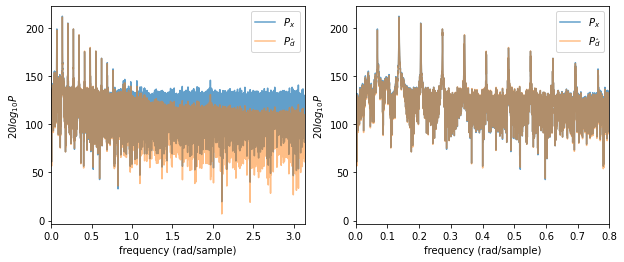

<Figure size 432x288 with 0 Axes>

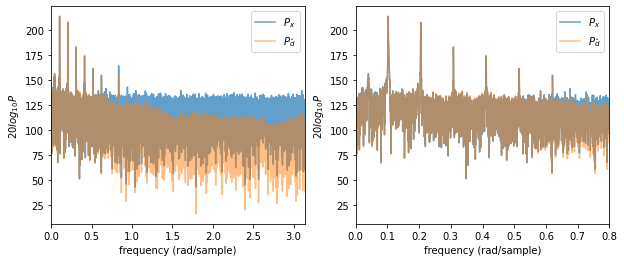

<Figure size 432x288 with 0 Axes>

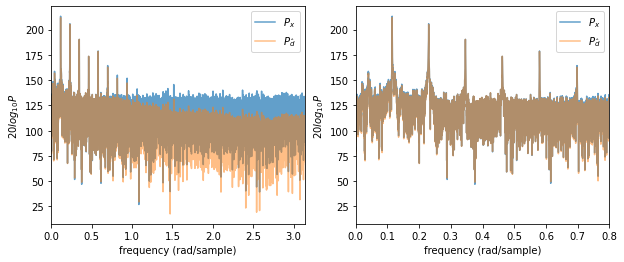

In [42]:
time_step = 1/22050
freq = 22050
ps1 =np.abs(np.fft.fft(x_0))**2/N
freqs1 = np.fft.fftfreq(ps1.size, time_step)*(2*np.pi/freq)
idx1 = np.argsort(freqs1)

ps2 =np.abs(np.fft.fft(signal_0))**2/N
freqs2 = np.fft.fftfreq(ps2.size, time_step)*(2*np.pi/freq)
idx2 = np.argsort(freqs2)

plt.figure()
plt.figure().set_figwidth(10)
plt.subplot(1, 2, 1)
plt.plot(freqs1[idx1], 20*np.log10(ps1[idx1]),alpha=0.7, label = '$P_x$')
plt.plot(freqs2[idx2], 20*np.log10(ps2[idx2]),alpha=0.5, label = '$P_{\hat{d}}$')
plt.xlabel("frequency (rad/sample)")
plt.ylabel("$20log_{10}P$")
plt.xlim([0, np.pi])
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(freqs1[idx1], 20*np.log10(ps1[idx1]),alpha=0.7,label = '$P_x$')
plt.plot(freqs2[idx2], 20*np.log10(ps2[idx2]),alpha=0.5,label = '$P_{\hat{d}}$')
plt.xlabel("frequency (rad/sample)")
plt.ylabel("$20log_{10}P$")
plt.xlim([0,0.8])
plt.legend()
plt.show()

ps3 =np.abs(np.fft.fft(x_1))**2/N
freqs3 = np.fft.fftfreq(ps3.size, time_step)*(2*np.pi/freq)
idx3 = np.argsort(freqs3)

ps4 =np.abs(np.fft.fft(signal_1))**2/N
freqs4 = np.fft.fftfreq(ps4.size, time_step)*(2*np.pi/freq)
idx4 = np.argsort(freqs4)

plt.figure()
plt.figure().set_figwidth(10)
plt.subplot(1, 2, 1)
plt.plot(freqs3[idx3], 20*np.log10(ps3[idx3]),alpha=0.7,label = '$P_x$')
plt.plot(freqs4[idx4], 20*np.log10(ps4[idx4]),alpha=0.5,label = '$P_{\hat{d}}$')
plt.xlabel("frequency (rad/sample)")
plt.ylabel("$20log_{10}P$")
plt.xlim([0, np.pi])
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(freqs3[idx3], 20*np.log10(ps3[idx3]),alpha=0.7,label = '$P_x$')
plt.plot(freqs4[idx4], 20*np.log10(ps4[idx4]),alpha=0.5,label = '$P_{\hat{d}}$')
plt.xlabel("frequency (rad/sample)")
plt.ylabel("$20log_{10}P$")
plt.xlim([0,0.8])
plt.legend()
plt.show()

ps5 =np.abs(np.fft.fft(x_2))**2/N
freqs5 = np.fft.fftfreq(ps5.size, time_step)*(2*np.pi/freq)
idx5 = np.argsort(freqs5)

ps6 =np.abs(np.fft.fft(signal_2))**2/N
freqs6 = np.fft.fftfreq(ps6.size, time_step)*(2*np.pi/freq)
idx6 = np.argsort(freqs6)

plt.figure()
plt.figure().set_figwidth(10)
plt.subplot(1, 2, 1)
plt.plot(freqs5[idx5], 20*np.log10(ps5[idx5]),alpha=0.7,label = '$P_x$')
plt.plot(freqs6[idx6], 20*np.log10(ps6[idx6]), alpha=0.5,label = '$P_{\hat{d}}$')
plt.xlabel("frequency (rad/sample)")
plt.ylabel("$20log_{10}P$")
plt.xlim([0, np.pi])
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(freqs5[idx5], 20*np.log10(ps5[idx5]),alpha=0.7,label = '$P_x$')
plt.plot(freqs6[idx6], 20*np.log10(ps6[idx6]),alpha=0.5,label = '$P_{\hat{d}}$')
plt.xlabel("frequency (rad/sample)")
plt.ylabel("$20log_{10}P$")
plt.xlim([0,0.8])
plt.legend()
plt.show()


> From the peridiograms we can conclude that the filter reduces the noise for higher frequencies, while for lower frequencies, which also represent the parts of the signal with higher power spectrum, the original signal is almost the same as the denoised one. 

**9. (15 points)** Now that you've heard the filtered audio, you may naturally be unimpressed with the results. Determined to improve the results you obtained, you decide investigate the effect of the filter order on the estimate of the audio bitstream. To do so, you vary the filter order between $m= 2$ and $m= 500$. 
To focus your experiments, you choose only a single piano key and focus on that audio file.

What filter order would you choose in order to filter the audio signal? Around what number does an increase in filter order no longer yield a significant improvement?

To justify your answer, you may want to look at the value of the cost function $ J(w(i)) = E [|e(n;w(i))|^2] $

Plot the denoised signal with the filter order of your choice along with the originally received one. Play the new audio. Do you notice any improvements over the original audio or the signal obtained with the 10th order filter?


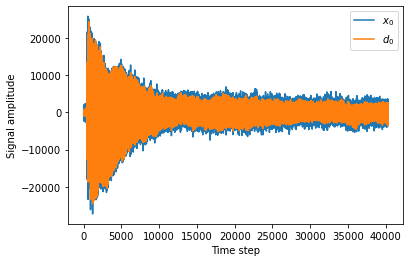

In [43]:
v = noise_measured
x_0 = data_noised[0]
r_x_0 = []
r_v = []
values = []


for k in range(0,500):
    a = 0
    b = 0
    for i in range(k+1,Nnoise):
        a = a+v[i]*np.conjugate(v[i-k])
    r_v.append(a/(Nnoise-k))
    
    for i in range(k+1,N):
        b = b+x_0[i]*np.conjugate(x_0[i-k])
    r_x_0.append(b/(N-k))

r_d_x_0 = np.subtract(r_x_0,r_v)

for N_order in range(2,500, 10):
    
    values.append(-np.dot(np.dot(np.transpose(r_d_x_0[0:N_order]),lin.pinv(lin.toeplitz(r_x_0[0:N_order]))),r_d_x_0[0:N_order]))
    
    
w_0 = np.dot(lin.inv(lin.toeplitz(r_x_0[0:400])),(r_d_x_0[0:400]))
a_coef = np.concatenate(([1], np.zeros(w_0.size-1)))
                         
signal_0 = sig.lfilter(w_0,a_coef,x_0)
play_signal(signal_0)

plt.figure()
plt.plot(x_0, label = '$x_0$')
plt.plot(signal_0, label = '$d_0$')
plt.xlabel("Time step")
plt.ylabel("Signal amplitude")
plt.legend()
plt.show()

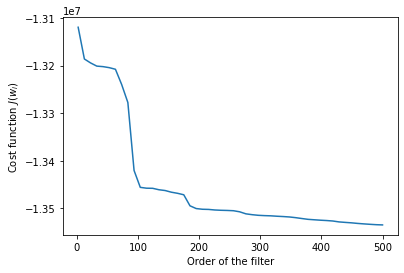

In [44]:
plt.figure()
plt.plot(np.linspace(2,500,50),values)
plt.xlabel("Order of the filter")
plt.ylabel("Cost function $J(w_i)$")
plt.show()

>To know how much the order of the filter influences the quality of the denoised signal, we proceeded to look at the value of the cost function $ J(w(i)) = E [|e(n;w(i))|^2] $. The Minimum Variance FIR Wiener Problem aims to minimise the cost function $J(w)$ by finding the values of the coefficients $w$ and the order of the Wiener filter that satisfy that purpose. Therefore, by analysing how the cost function behaves for different orders of the filter, we can check around what number does an increase in filter order no longer yield a significant improvement in the denoised signal. 
>
>From the plot above for the cost function in terms of the order of the filter we can notice that after the order 200 the cost function no longer has a significant improvement no matter how higher the order of the filter is. We can also see that for the 10th order filter the cost function value is higher than the ones for orders greater than 200. This means that for the 10th order filter the cost function hasn't yet reached its minimum which explains the improvement in the audio when higher orders of the filter are chosen. Thus, we decided to try the filter with order 400. However, we can also realise that the difference between the cost function for the 10th order filter and for the 400th order or above is not that high. The values of the cost function are all still around 1.3e7, which also explains that, even though there is an improvement between both orders of the filter (also seen in the plot from the denoised and original signals) and we can definitely tell there is a small difference in the different audios when listening to them, the denoised signal is still not completely clear.   